<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/0518%20Time%20Series%20Analysis%20Practice/Assignment%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis Assignment

실습 시간에 다룬 코드 또는 참고용으로 주어진 코드를 바탕으로 해서 시계열 분석을 수행하는 과제입니다.

방법론은 자유이고, 단변량 시계열 분석 중 적절한 방법을 사용해서 예측을 수행하시면 됩니다.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from pylab import rcParams
import statsmodels.api as sm
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA as ARIMA
%pip install pmdarima
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

## 데이터셋 설명 및 제출 양식

* oil dataset으로, 일별 석유 가격을 나타낸 데이터입니다. WTI(West Texas Intermediate)기준입니다.
2013년 1월 2일부터 2023년 5월 8일까지의 유가 데이터입니다.  

* 아래 notebook의 흐름에 따라 시계열 예측을 수행하고, Data Preprocessing 파트에 있는 질문에 대한 답에 대한 word문서, 시계열 분석에 대한 code를 제출하시면 됩니다.

### Dataset 불러오기

In [6]:
df = pd.read_csv('/content/drive/MyDrive/BADA/0518 시계열분석 실습/Oilprice_wti.csv', parse_dates=['date'])
df.head(10)

,date,dcoilwtico
0,2013-01-02,93.14
1,2013-01-03,92.97
2,2013-01-04,93.12
3,2013-01-07,93.20
4,2013-01-08,93.21
5,2013-01-09,93.08
6,2013-01-10,93.81
7,2013-01-11,93.60
8,2013-01-14,94.27
9,2013-01-15,93.26


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2699 entries, 0 to 2698
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2699 non-null   datetime64[ns]
 1   dcoilwtico  2598 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.3 KB


In [8]:
df = df.rename(columns={'dcoilwtico':'y'})
df = df.rename(columns={'date':'ds'})
df = df.set_index('ds')
df.head()

,y
ds,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
2013-01-08,93.21


# Data Preprocessing

1. 결측치를 어떻게 처리하면 좋을까요?

2. Holiday에 대한 labeling이 필요할까요, 필요하지 않을까요?

3. 반드시 제거해 줘야 할 이상치가 있습니다. 해당 구간을 식별하고 그 이상치가 발생한 원인을 찾아서 제시해 주세요. 또한 이상치를 처리할 방법에 대해서도 제시해 주세요.

4. Prophet modeling을 사용할 경우, 1차시 세션 때 제시했듯 exogeneous shock은 배제하는 것이 효과적인 학습을 위해 적절합니다. 주어진 기간 동안 유가(WTI)에 미칠 수 있는 exogeneous shock에는 무엇이 있을지 식별해 볼까요?

## 1번

In [9]:
#결측치 확인
missing_values = df['y'].isnull().sum()
print("Nan:", missing_values)

Nan: 101


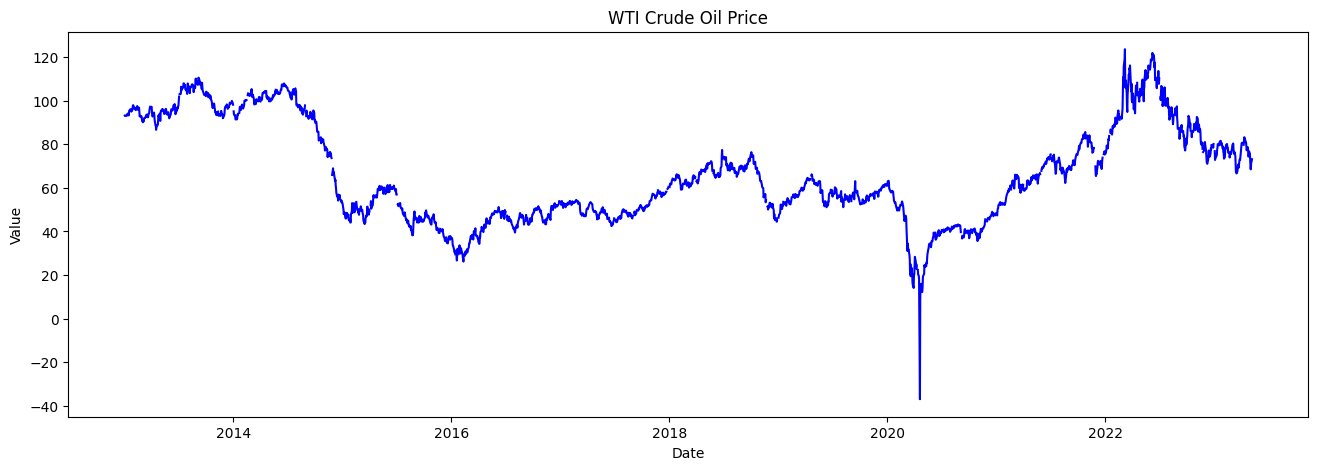

In [12]:
#시계열 그래프 그리기
def plot_ts(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_ts(df, x=df.index, y=df["y"], title="WTI Crude Oil Price")

In [13]:
#결측치를 이전 일의 데이터로 채우기
df_filled1 = df.copy()
df_filled1 = df_filled1.fillna(method = 'ffill')
missing_values = df_filled1['y'].isnull().sum()
print("Nan:", missing_values)

Nan: 0


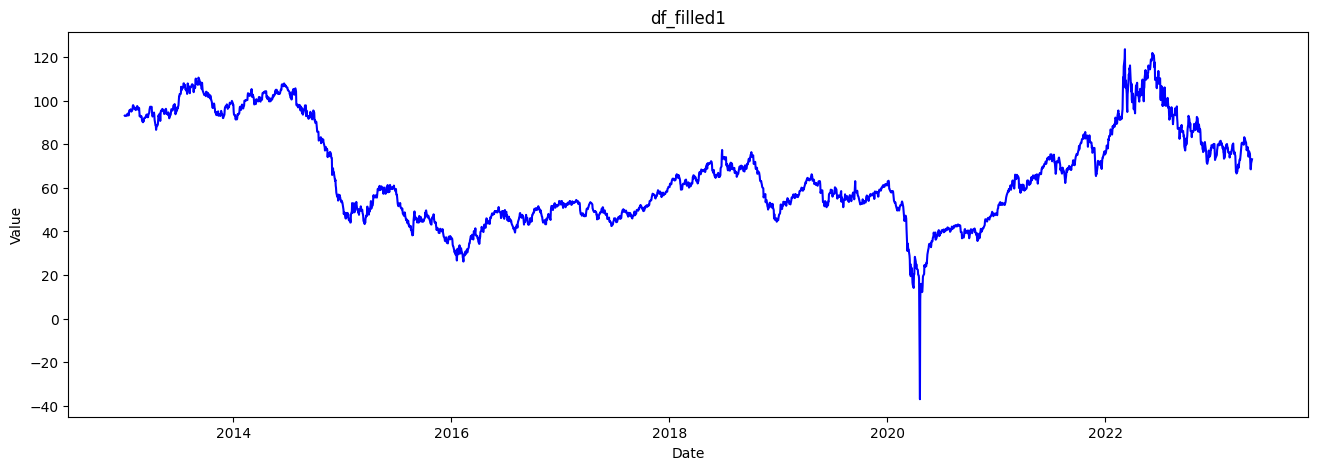

In [14]:
plot_ts(df_filled1, x=df_filled1.index, y=df_filled1["y"], title='df_filled1')

In [15]:
df.describe()

,y
count,2598.000000
mean,66.192590
std,22.502716
min,-36.980000
25%,48.800000
50%,60.705000
75%,84.517500
max,123.640000


In [16]:
#결측치를 스플라인 보간법으로 채우기
df_filled2 = df.copy()
df_filled2 = df_filled2.interpolate(method = 'spline', order = 3)
missing_values = df_filled2['y'].isnull().sum()
print("Nan:", missing_values)

Nan: 0


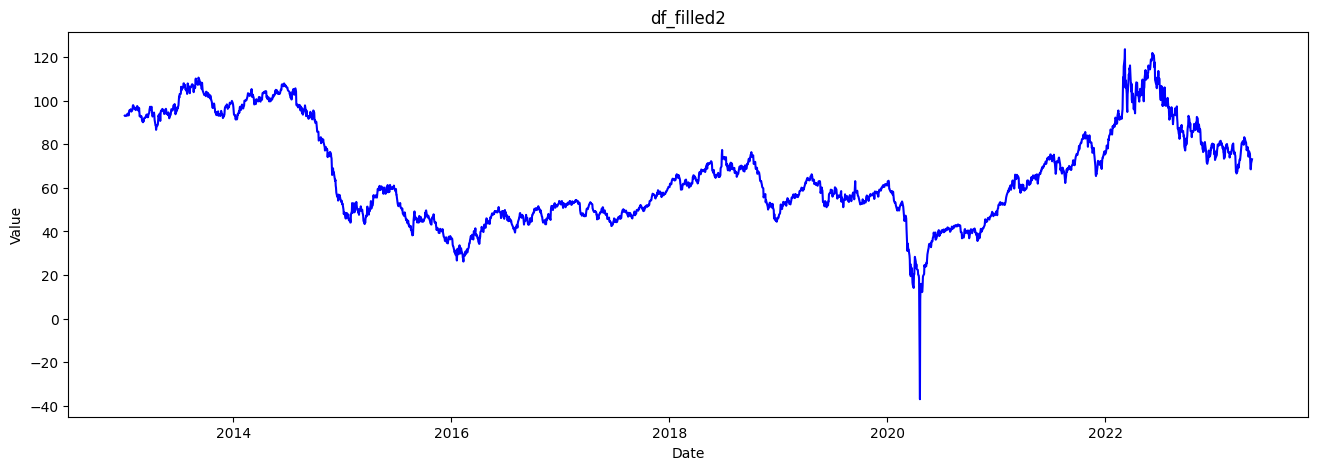

In [17]:
plot_ts(df_filled2, x=df_filled2.index, y=df_filled2["y"], title='df_filled2')

## 3번

In [35]:
df_filled2_ = df_filled2.copy()
df_filled2_.loc['2020-04-20':'2020-04-30', 'y']

ds
2020-04-20   -36.98
2020-04-21     8.91
2020-04-22    13.64
2020-04-23    15.06
2020-04-24    15.99
2020-04-27    12.17
2020-04-28    12.40
2020-04-29    15.04
2020-04-30    19.23
Name: y, dtype: float64

In [36]:
df_filled2_.loc['2020-04-20':'2020-04-30', 'y'] = 18.31
df_filled2_.loc['2020-04-20':'2020-04-30', 'y']

ds
2020-04-20    18.31
2020-04-21    18.31
2020-04-22    18.31
2020-04-23    18.31
2020-04-24    18.31
2020-04-27    18.31
2020-04-28    18.31
2020-04-29    18.31
2020-04-30    18.31
Name: y, dtype: float64

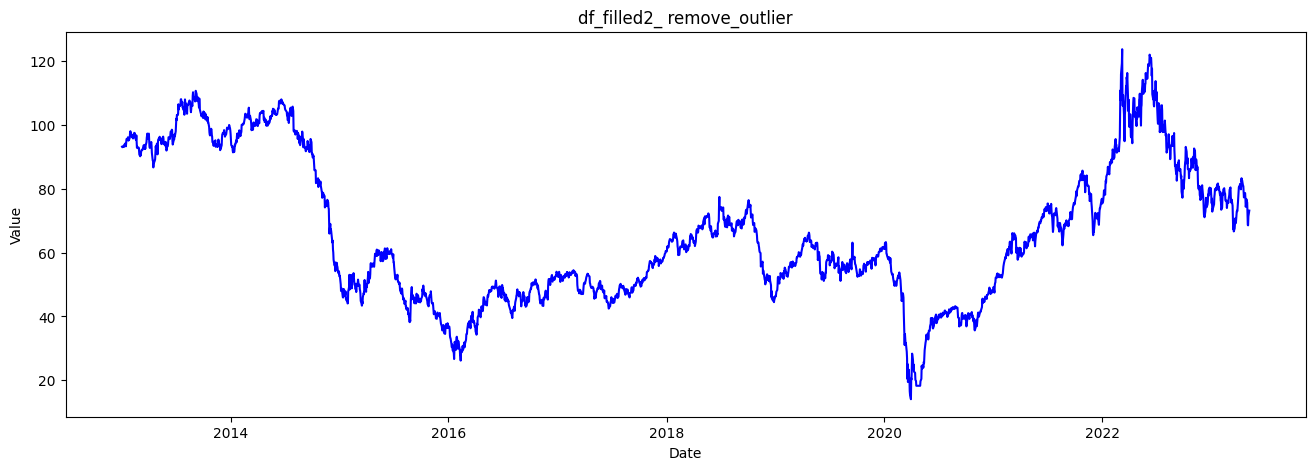

In [37]:
plot_ts(df_filled2_, x=df_filled2_.index, y=df_filled2_["y"], title='df_filled2_ remove_outlier')

In [38]:
df_filled2_.describe()

,y
count,2699.000000
mean,66.169589
std,22.374373
min,14.100000
25%,48.800000
50%,60.460000
75%,84.100000
max,123.640000


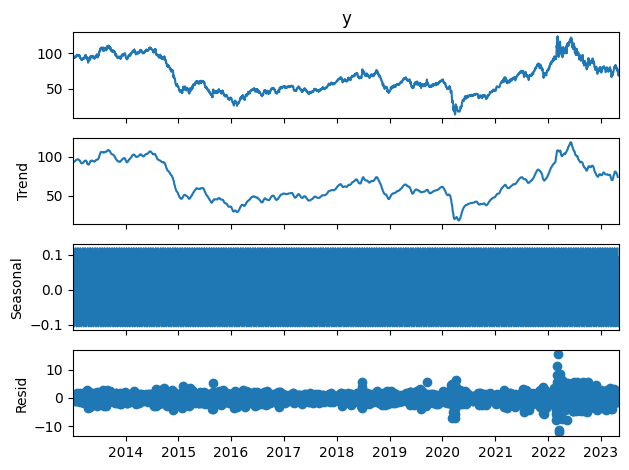

In [40]:
#시계열 분해 additive
dec = sm.tsa.seasonal_decompose(df_filled2_['y'], period = 12, model = 'additive').plot()
plt.show()

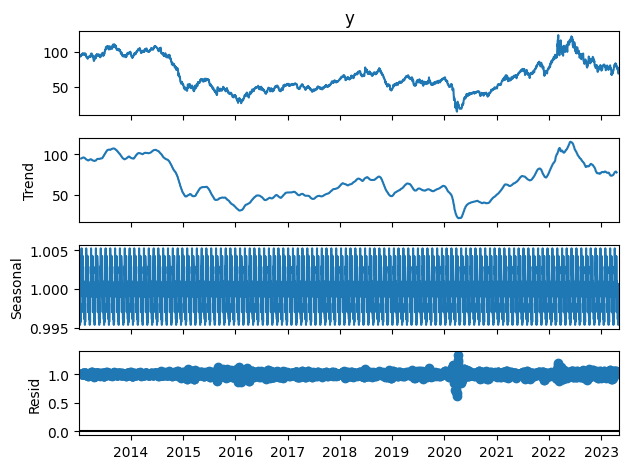

In [41]:
#시계열 분해 Multiplicative
dec = sm.tsa.seasonal_decompose(df_filled2_['y'], period = 24, model = 'multiplicative').plot()
plt.show()

# Model Fitting

## 4번

In [42]:
df_p = df_filled2_.reset_index(level = ['ds'], drop = False)
df_p.head()

,ds,y
0,2013-01-02,93.14
1,2013-01-03,92.97
2,2013-01-04,93.12
3,2013-01-07,93.20
4,2013-01-08,93.21


In [45]:
# train_test split
train_ratio = 0.7
train_size = int(len(df_p) * train_ratio)

train_data = df_p[:train_size]
test_data = df_p[train_size:]

In [46]:
print(train_data)

             ds      y
0    2013-01-02  93.14
1    2013-01-03  92.97
2    2013-01-04  93.12
3    2013-01-07  93.20
4    2013-01-08  93.21
...         ...    ...
1884 2020-03-24  21.03
1885 2020-03-25  20.75
1886 2020-03-26  16.60
1887 2020-03-27  15.48
1888 2020-03-30  14.10

[1889 rows x 2 columns]


### Checking the characteristics of time series data

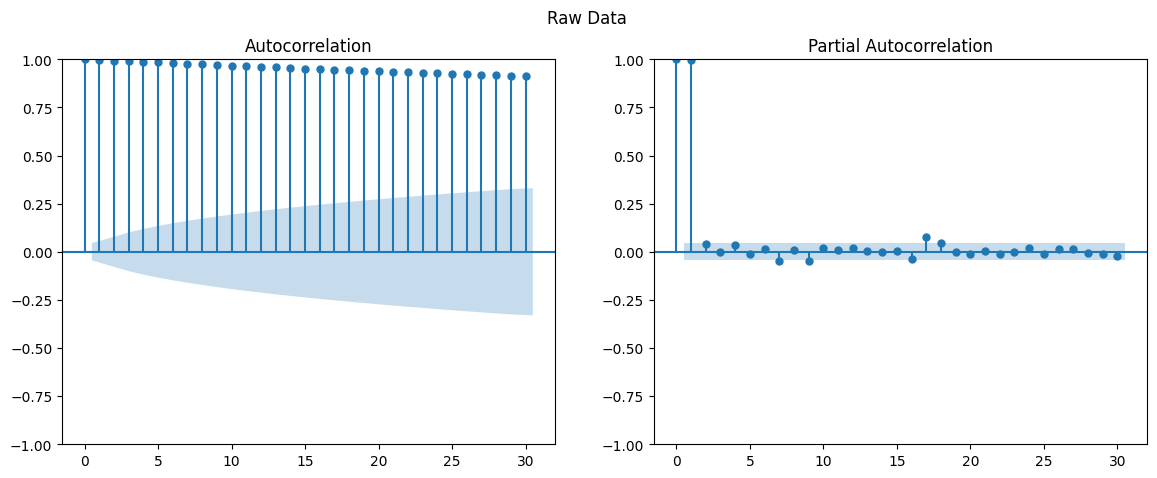

In [47]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
fig.suptitle("Raw Data")
sm.graphics.tsa.plot_acf(train_data.iloc[:, 1].squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.iloc[:, 1].squeeze(), lags=30, ax=ax[1]);

In [48]:
#Stationary Test: Augmented Dickey-Fuller
# H0: Non-stationary
# H1: Stationary

def adf_test(df):
    result = adfuller(df, autolag = 'AIC')
    print('ADF Statistic: {}'.format(round(result[0], 3)))
    print(40*'*')
    print('p-value:{}'.format(round(result[1], 5)))
    print(40*'*')
    for key, value in result[4].items():
        print('Critical Values:')
        print('{}:{}'.format(key, round(value, 3)))

adf_test(train_data['y'])

ADF Statistic: -0.8
****************************************
p-value:0.819
****************************************
Critical Values:
1%:-3.434
Critical Values:
5%:-2.863
Critical Values:
10%:-2.568


In [49]:
# KPSS test: stationarity around a trend

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critcial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(train_data['y'])

KPSS Statistic: 3.060377986153011
p-value: 0.01
num lags: 27
Critcial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [50]:
n_diffs = ndiffs(train_data['y'], max_d = 6)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [51]:
diff_train_data = train_data.copy()
diff_train_data['y'] = diff_train_data['y'].diff()
diff_train_data = diff_train_data.dropna()
print('######### Raw Data ########')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

######### Raw Data ########
             ds      y
0    2013-01-02  93.14
1    2013-01-03  92.97
2    2013-01-04  93.12
3    2013-01-07  93.20
4    2013-01-08  93.21
...         ...    ...
1884 2020-03-24  21.03
1885 2020-03-25  20.75
1886 2020-03-26  16.60
1887 2020-03-27  15.48
1888 2020-03-30  14.10

[1889 rows x 2 columns]
### Differenced Data ###
             ds     y
1    2013-01-03 -0.17
2    2013-01-04  0.15
3    2013-01-07  0.08
4    2013-01-08  0.01
5    2013-01-09 -0.13
...         ...   ...
1884 2020-03-24 -2.30
1885 2020-03-25 -0.28
1886 2020-03-26 -4.15
1887 2020-03-27 -1.12
1888 2020-03-30 -1.38

[1888 rows x 2 columns]


In [52]:
diff_test_data = test_data.copy()
diff_test_data['y'] = diff_test_data['y'].diff()
diff_test_data = diff_test_data.dropna()
print('######### Raw Data ########')
print(test_data)
print('### Differenced Data ###')
print(diff_test_data)

######### Raw Data ########
             ds      y
1889 2020-03-31  20.51
1890 2020-04-01  20.28
1891 2020-04-02  25.18
1892 2020-04-03  28.36
1893 2020-04-06  26.21
...         ...    ...
2694 2023-05-02  71.71
2695 2023-05-03  68.62
2696 2023-05-04  68.52
2697 2023-05-05  71.32
2698 2023-05-08  73.13

[810 rows x 2 columns]
### Differenced Data ###
             ds     y
1890 2020-04-01 -0.23
1891 2020-04-02  4.90
1892 2020-04-03  3.18
1893 2020-04-06 -2.15
1894 2020-04-07 -2.67
...         ...   ...
2694 2023-05-02 -3.94
2695 2023-05-03 -3.09
2696 2023-05-04 -0.10
2697 2023-05-05  2.80
2698 2023-05-08  1.81

[809 rows x 2 columns]


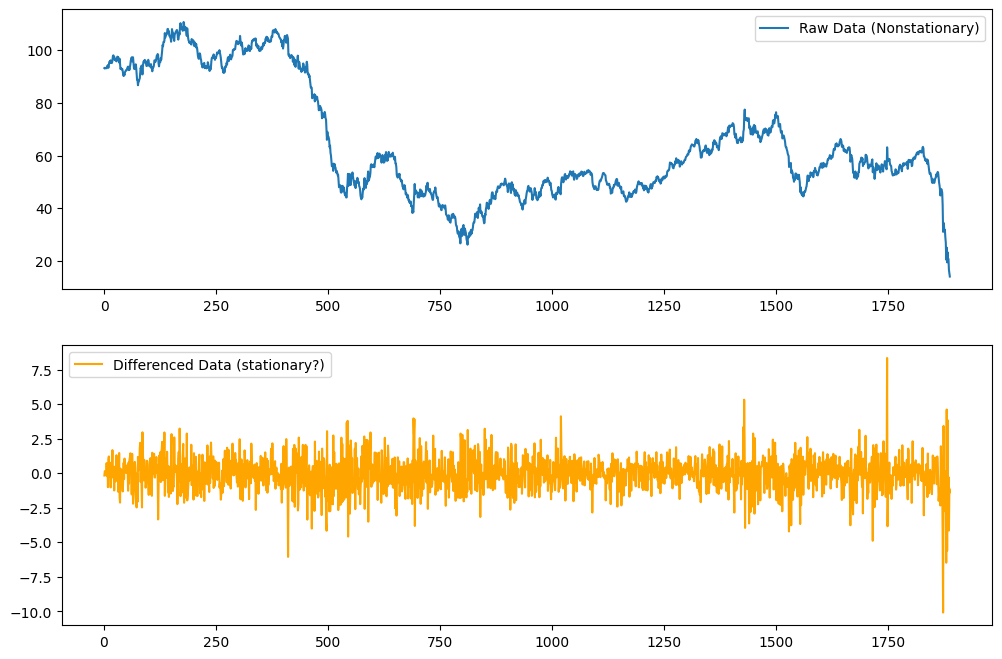

In [53]:
#differenced data plot
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['y'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data['y'],'orange')
plt.legend(['Differenced Data (stationary?)'])
plt.show()

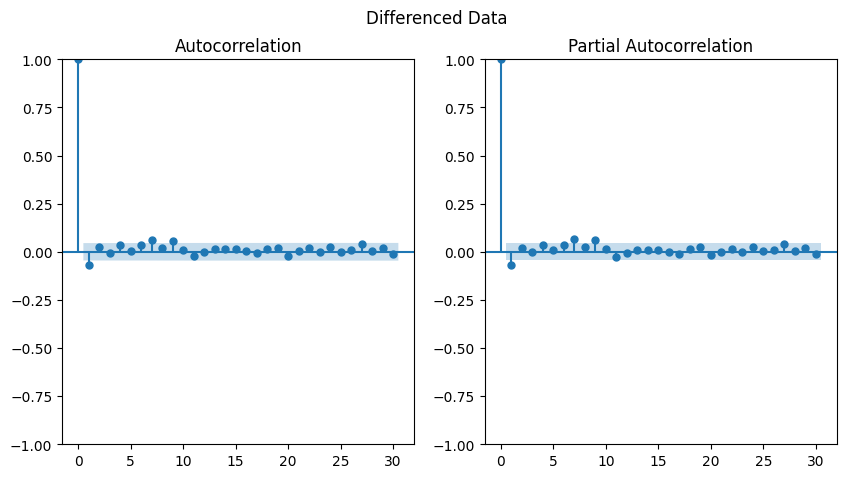

In [54]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Differenced Data")
sm.graphics.tsa.plot_acf(diff_train_data['y'].squeeze(), lags=30, ax=ax[0])  #acf
sm.graphics.tsa.plot_pacf(diff_train_data['y'].squeeze(), lags=30, ax=ax[1])  #pacf
plt.show()

In [55]:
adf_test(diff_train_data['y'])

ADF Statistic: -11.919
****************************************
p-value:0.0
****************************************
Critical Values:
1%:-3.434
Critical Values:
5%:-2.863
Critical Values:
10%:-2.568


In [56]:
kpss_test(diff_train_data['y'])

KPSS Statistic: 0.19181501411687066
p-value: 0.1
num lags: 5
Critcial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [57]:
# log transformation with np.log()
train_log = train_data.copy()
train_log['y'] = np.log(train_log['y'])
diff_train_log = train_log.copy()
diff_train_log['y'] = diff_train_log['y'].diff()
diff_train_log = diff_train_log.dropna()
print('######### Raw Data ########')
print(train_data)
print('### logged Differenced Data ###')
print(diff_train_log)

######### Raw Data ########
             ds      y
0    2013-01-02  93.14
1    2013-01-03  92.97
2    2013-01-04  93.12
3    2013-01-07  93.20
4    2013-01-08  93.21
...         ...    ...
1884 2020-03-24  21.03
1885 2020-03-25  20.75
1886 2020-03-26  16.60
1887 2020-03-27  15.48
1888 2020-03-30  14.10

[1889 rows x 2 columns]
### logged Differenced Data ###
             ds         y
1    2013-01-03 -0.001827
2    2013-01-04  0.001612
3    2013-01-07  0.000859
4    2013-01-08  0.000107
5    2013-01-09 -0.001396
...         ...       ...
1884 2020-03-24 -0.103790
1885 2020-03-25 -0.013404
1886 2020-03-26 -0.223144
1887 2020-03-27 -0.069854
1888 2020-03-30 -0.093374

[1888 rows x 2 columns]


In [59]:
adf_test(diff_train_log['y'])

ADF Statistic: -6.008
****************************************
p-value:0.0
****************************************
Critical Values:
1%:-3.434
Critical Values:
5%:-2.863
Critical Values:
10%:-2.568


In [60]:
kpss_test(diff_train_log['y'])

KPSS Statistic: 0.36000875760334333
p-value: 0.09439277689511064
num lags: 8
Critcial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


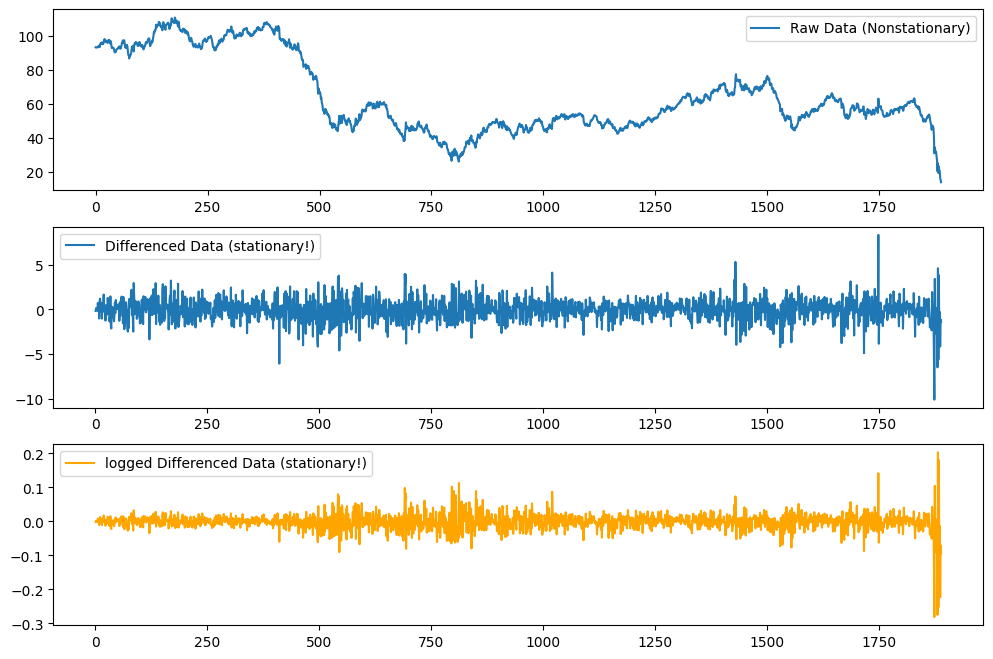

In [58]:
#differenced data plot
plt.figure(figsize=(12,8))

plt.subplot(311)
plt.plot(train_data['y'])
plt.legend(['Raw Data (Nonstationary)'])

plt.subplot(312)
plt.plot(diff_train_data['y'])
plt.legend(['Differenced Data (stationary!)'])

plt.subplot(313)
plt.plot(diff_train_log['y'],'orange')
plt.legend(['logged Differenced Data (stationary!)'])
plt.show()

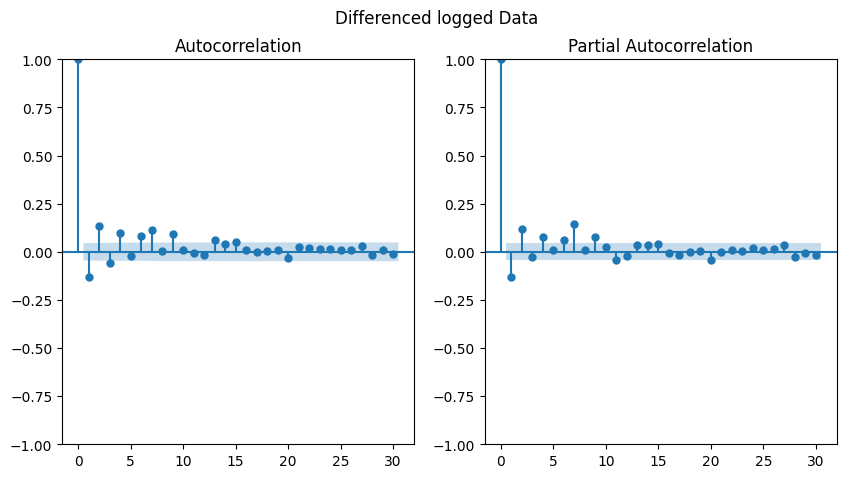

In [61]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Differenced logged Data")
sm.graphics.tsa.plot_acf(diff_train_log['y'].squeeze(), lags=30, ax=ax[0])  #acf
sm.graphics.tsa.plot_pacf(diff_train_log['y'].squeeze(), lags=30, ax=ax[1])  #pacf
plt.show()

In [62]:
test_log = test_data.copy()
test_log['y'] = np.log(test_log['y'])
diff_test_log = test_log.copy()
diff_test_log['y'] = diff_test_log['y'].diff()
diff_test_log = diff_test_log.dropna()
print('######### Raw Data ########')
print(test_data)
print('### logged Differenced Data ###')
print(diff_test_log)

######### Raw Data ########
             ds      y
1889 2020-03-31  20.51
1890 2020-04-01  20.28
1891 2020-04-02  25.18
1892 2020-04-03  28.36
1893 2020-04-06  26.21
...         ...    ...
2694 2023-05-02  71.71
2695 2023-05-03  68.62
2696 2023-05-04  68.52
2697 2023-05-05  71.32
2698 2023-05-08  73.13

[810 rows x 2 columns]
### logged Differenced Data ###
             ds         y
1890 2020-04-01 -0.011277
1891 2020-04-02  0.216415
1892 2020-04-03  0.118930
1893 2020-04-06 -0.078839
1894 2020-04-07 -0.107440
...         ...       ...
2694 2023-05-02 -0.053487
2695 2023-05-03 -0.044046
2696 2023-05-04 -0.001458
2697 2023-05-05  0.040051
2698 2023-05-08  0.025062

[809 rows x 2 columns]


### Fitting Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/ucqt0xh_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/w3sodjzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39065', 'data', 'file=/tmp/tmpxpk6yokd/ucqt0xh_.json', 'init=/tmp/tmpxpk6yokd/w3sodjzf.json', 'output', 'file=/tmp/tmpxpk6yokd/prophet_modelvx6_pz_8/prophet_model-20231104113544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:35:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:35:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


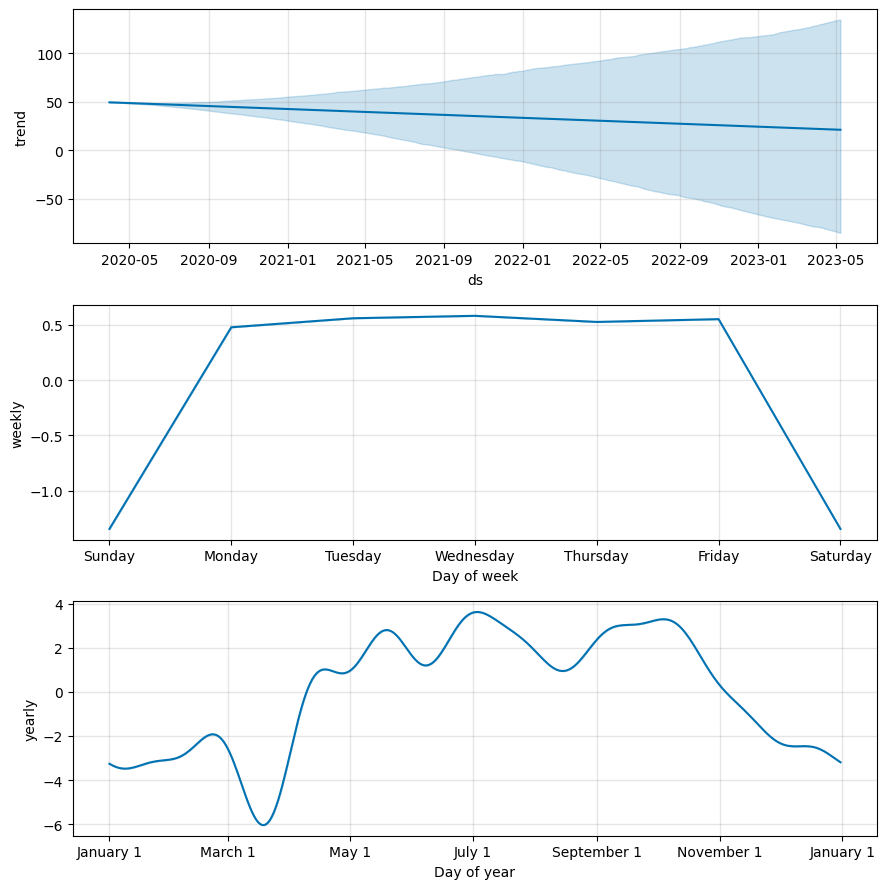

In [63]:
#파라미터 조정하지 않고 prophet으로 예측한 경우
model = Prophet()
model.fit(train_data)
forecast = model.predict(test_data)
model.plot_components(forecast)
plt.show()

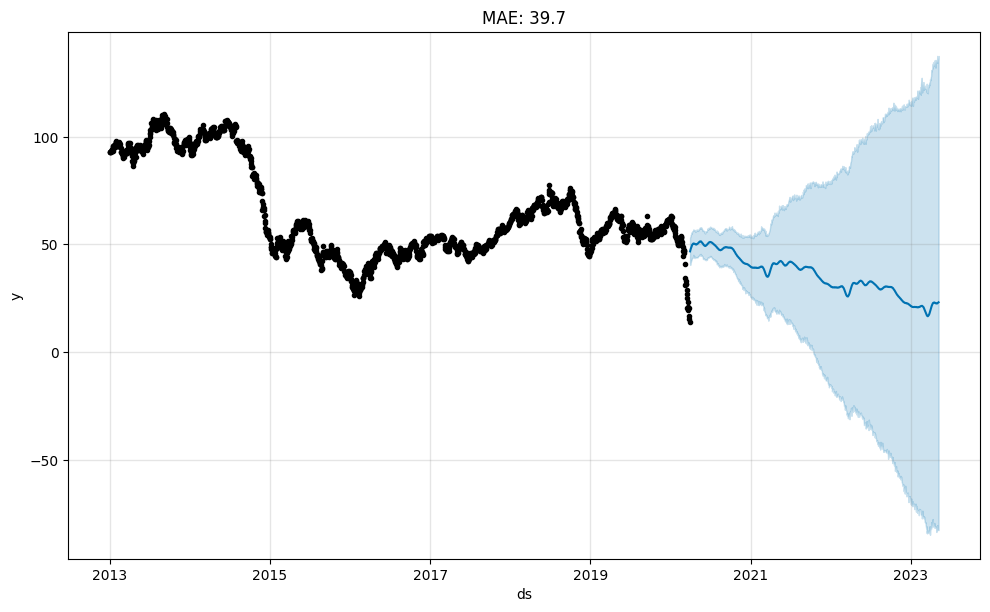

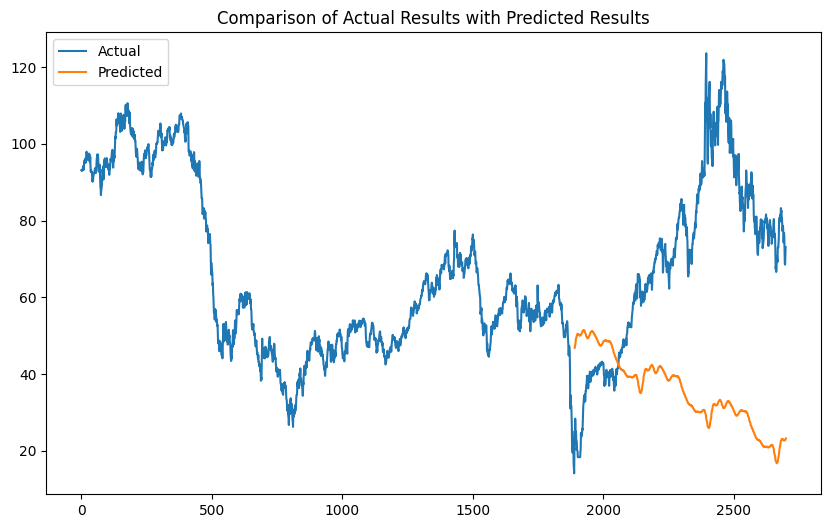

In [64]:
mae = mean_absolute_error(test_data['y'], forecast['yhat'])
model.plot(forecast, figsize=(10,6))
plt.title(f"MAE: {round(mae, 2)}")
plt.show()

split_index = len(train_data)
forecast.index = forecast.index + split_index +1
plt.figure(figsize=(10,6))
plt.plot(df_p['y'], label='Actual')
plt.plot(forecast['yhat'], label='Predicted')
plt.legend()
plt.title('Comparison of Actual Results with Predicted Results')
plt.show()

### parameter 조정

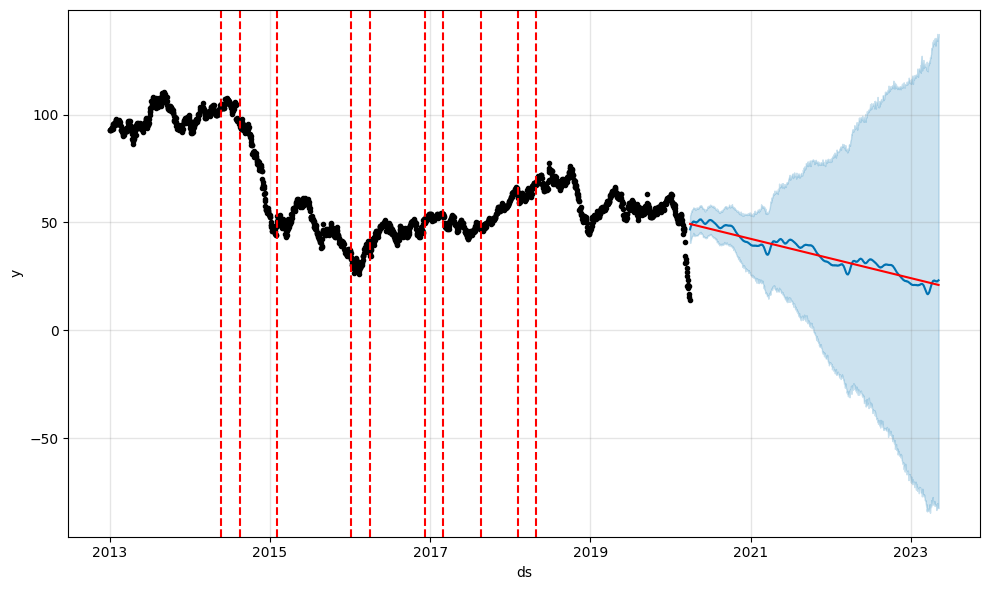

In [65]:
#trend
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/ibep2e3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/mg6pmf_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6938', 'data', 'file=/tmp/tmpxpk6yokd/ibep2e3r.json', 'init=/tmp/tmpxpk6yokd/mg6pmf_0.json', 'output', 'file=/tmp/tmpxpk6yokd/prophet_modeld_hu1pi5/prophet_model-20231104114212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


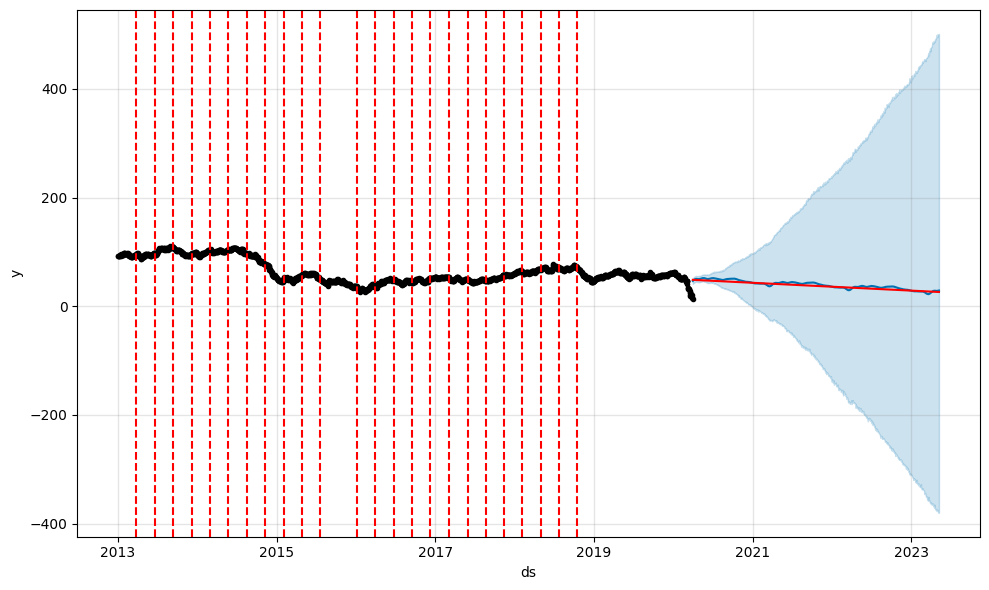

In [70]:
m = Prophet(changepoint_prior_scale=0.7)
m.fit(train_data)
forecast = m.predict(test_data)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/lpfs1k81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/j_y6ke2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7475', 'data', 'file=/tmp/tmpxpk6yokd/lpfs1k81.json', 'init=/tmp/tmpxpk6yokd/j_y6ke2w.json', 'output', 'file=/tmp/tmpxpk6yokd/prophet_modeltk8kpkwj/prophet_model-20231104114250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


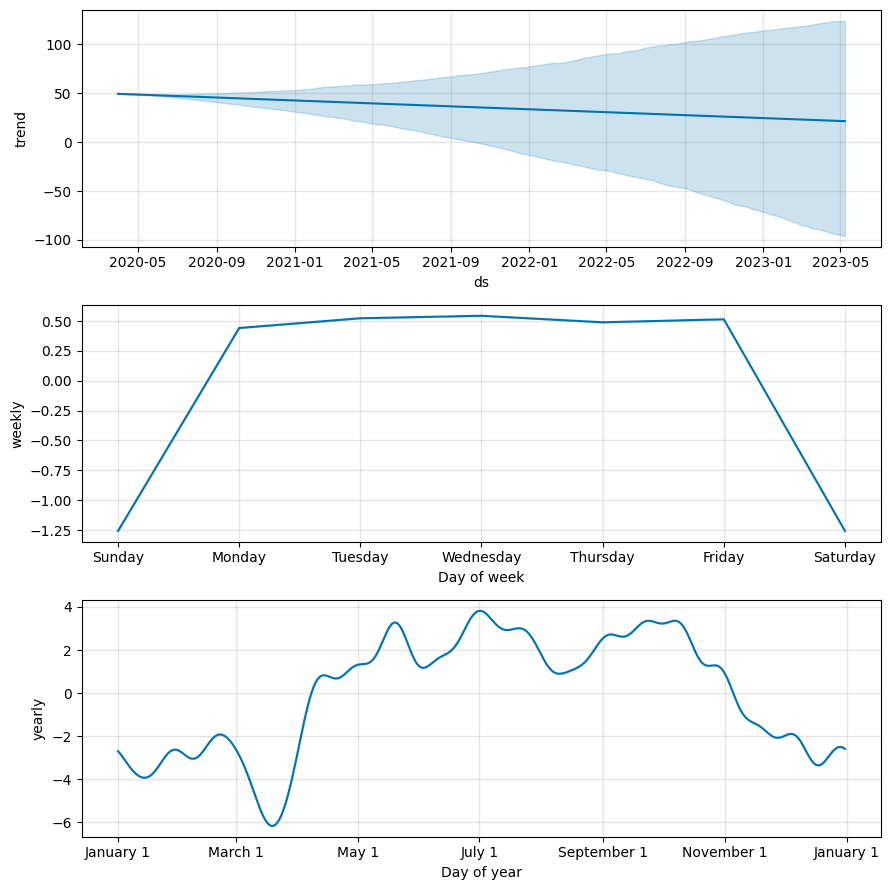

In [72]:
m = Prophet(yearly_seasonality=20)

m.fit(train_data)
forecast = m.predict(test_data)
fig = m.plot_components(forecast)
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/dv74ss5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpk6yokd/ozj4xwa8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27308', 'data', 'file=/tmp/tmpxpk6yokd/dv74ss5z.json', 'init=/tmp/tmpxpk6yokd/ozj4xwa8.json', 'output', 'file=/tmp/tmpxpk6yokd/prophet_modelfzo5yf5t/prophet_model-20231104115208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


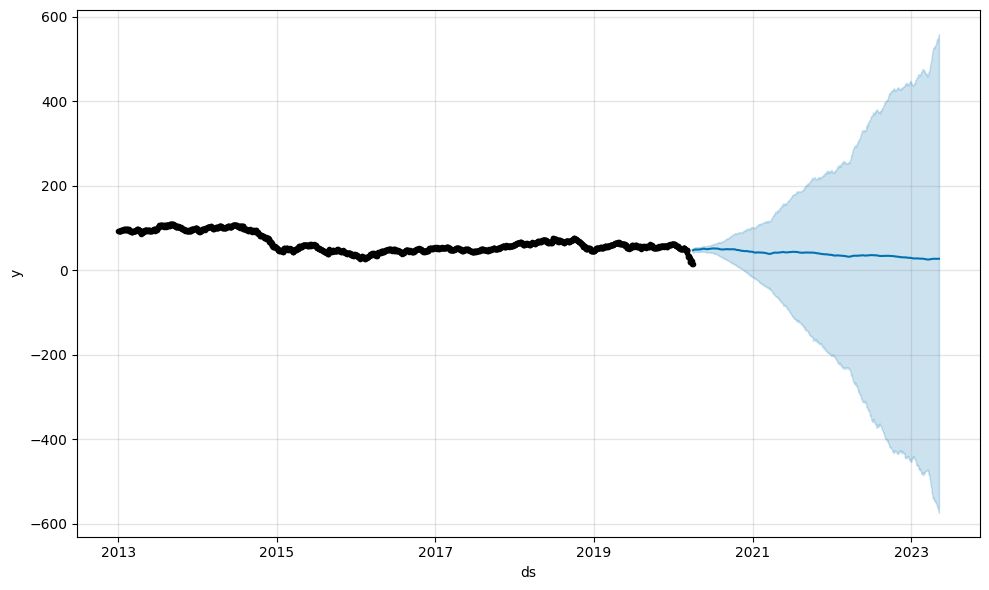

In [84]:
m = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=20,
    changepoint_prior_scale=0.7
)

m.fit(train_data)
forecast1 = m.predict(test_data)
fig = m.plot(forecast1)
plt.show()

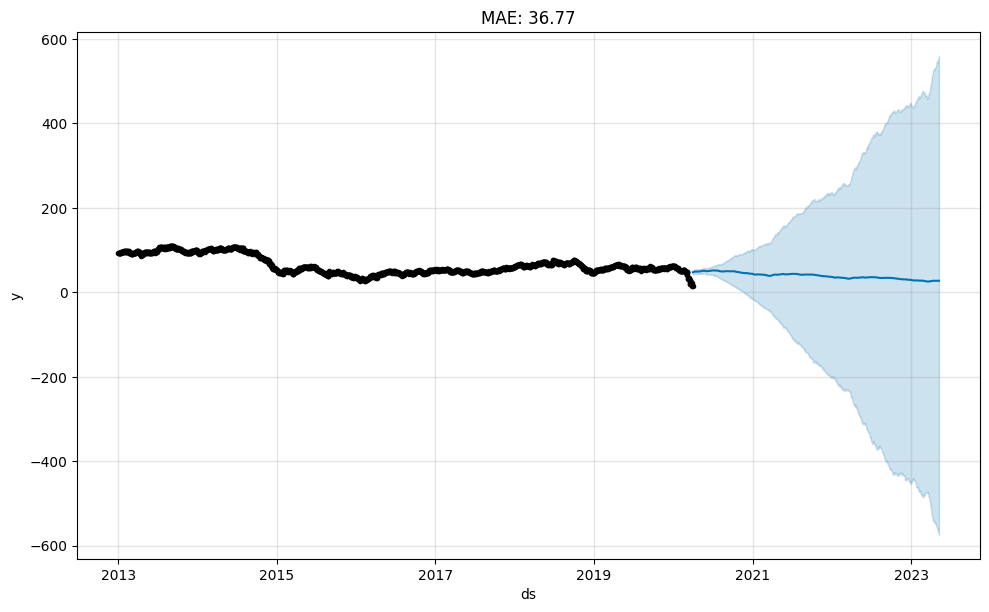

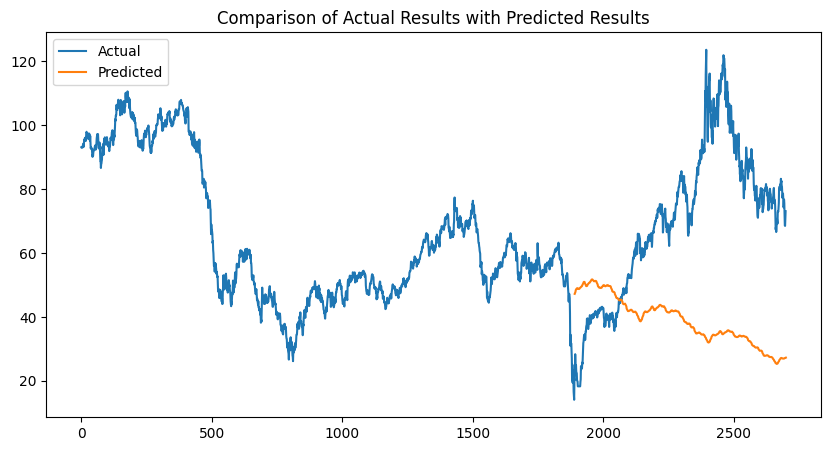

In [85]:
mae = mean_absolute_error(test_data['y'], forecast1['yhat'])
m.plot(forecast1, figsize=(10,6))
plt.title(f"MAE: {round(mae, 2)}")
plt.show()

forecast1.index = forecast1.index + split_index + 1
plt.figure(figsize=(10, 5))
plt.plot(df_p['y'], label='Actual')
plt.plot(forecast1['yhat'], label='Predicted')
plt.legend()
plt.title('Comparison of Actual Results with Predicted Results')
plt.show()

전보다 mse는 감소했으나, train set과 test set의 구분 지점의 감소 경향으로 인해 점차 값이 감소할 것으로 예측

### Evaluation

In [100]:
#모델 평가하는 class
class TSEvaluater:
    def evaluate_rmse(self, target, prediction):
        merged_df = pd.merge(target, prediction, on='ds', how='inner')
        rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))
        return round(rmse, 3)

    def plot_comparison(self, target, prediction):
        plt.figure(figsize=(10, 6))
        plt.plot(target['ds'], target['y'], label='Target')
        plt.plot(prediction['ds'], prediction['yhat'], label='Prediction')
        plt.xlabel('ds')
        plt.ylabel('y')
        plt.title('Target vs Prediction')
        plt.legend()
        plt.show()

In [97]:
TSEvaluater().evaluate_rmse(test_data, forecast1)

42.813

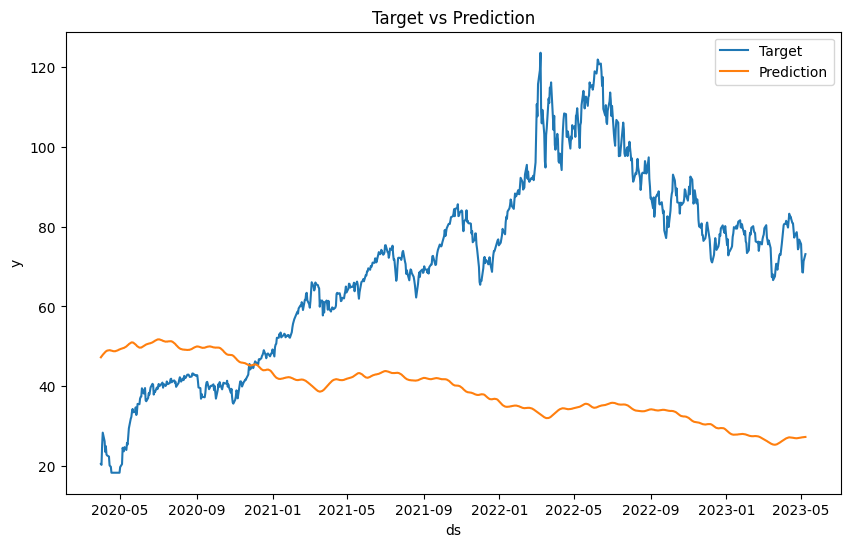

In [101]:
TSEvaluater().plot_comparison(test_data, forecast1)

In [102]:
from prophet.plot import plot_plotly, plot_components_plotly

In [103]:
plot_plotly(model, forecast)